# Super-Resolution Testing for Trained Operator

Test the trained FNO model on higher resolution grids to evaluate zero-shot super-resolution capabilities.


In [1]:
import torch
from neuralop.models import FNO
from operator_data_pipeline import GridDataset
from godunov_solver.solve_class import Godunov, SVESolver
from godunov_solver.flux import Greenshields, Triangular
from godunov_solver.plotter import plot_comparison
import matplotlib.pyplot as plt
import numpy as np


## 1. Setup High-Resolution Dataset


In [2]:
# Training resolution (should match your training parameters)
train_nx = 50
train_nt = 500
train_dx = 0.1
train_dt = 0.01

# Physical domain size (must remain constant!)
# Domain length: train_nx * train_dx = 50 * 0.25 = 12.5
# Total time: train_nt * train_dt = 250 * 0.05 = 12.5

# High-resolution parameters (2x finer grid, same domain)
high_nx = train_nx   # 2x spatial resolution
high_nt = train_nt   # 2x temporal resolution
high_dx = train_dx   # 0.125 (half the spacing)
high_dt = train_dt   # 0.025 (half the time step)

# Verify domain sizes match
print(f"Training domain: {train_nx * train_dx:.2f} x {train_nt * train_dt:.2f}")
print(f"High-res domain: {high_nx * high_dx:.2f} x {high_nt * high_dt:.2f}")
print()

# Create solver (match your training setup)
solver = Godunov(flux=Greenshields(vmax=1.0, rho_max=1.0))

# Generate high-resolution test samples
n_test_samples = 5
high_res_dataset = GridDataset(solver, n_test_samples, high_nx, high_nt, high_dx, high_dt)

print(f"Generated {len(high_res_dataset)} high-resolution samples")
print(f"Input shape: {high_res_dataset[0][0].shape}")  # (in_channels, nt, nx)
print(f"Target shape: {high_res_dataset[0][1].shape}")  # (out_channels, nt, nx)


Training domain: 5.00 x 5.00
High-res domain: 5.00 x 5.00

________________________________________________________________________________
[Memory] Calling operator_data_pipeline.generate_data...
generate_data(<godunov_solver.solve_class.Godunov object at 0x7f89546c6cf0>, 5, 50, 500, 0.1, 0.01)


Generating grids: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

____________________________________________________generate_data - 2.1s, 0.0min
Generated 5 high-resolution samples
Input shape: torch.Size([3, 500, 50])
Target shape: torch.Size([1, 500, 50])


## 2. Load Trained Model


In [3]:
# Model configuration (must match training parameters)
model = FNO(
    n_modes=(128, 64),        # modes in (time, space) dimensions
    hidden_channels=64,       # network width
    in_channels=3,            # density + time + space coords
    out_channels=1,           # predicted density
    n_layers=4                # number of FNO layers
)

# Load trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("operator.pth", map_location=device, weights_only=False))
model = model.to(device)
model.eval()

print(f"Model loaded successfully on {device}")
print(f"Model expects input: (batch, {model.in_channels}, time, space)")
print(f"Model outputs: (batch, {model.out_channels}, time, space)")


Model loaded successfully on cuda
Model expects input: (batch, 3, time, space)
Model outputs: (batch, 1, time, space)


## 3. Predict on High-Resolution Grid


In [7]:
# Select a test sample
sample_idx = 0
input_data, target_data = high_res_dataset[sample_idx]

# Add batch dimension and move to device
input_batch = input_data.unsqueeze(0).to(device)  # (1, 3, nt, nx)
target_batch = target_data.unsqueeze(0).to(device)  # (1, 1, nt, nx)

# Make prediction
with torch.no_grad():
    prediction = model(input_batch)  # (1, 1, nt, nx)

# Convert to numpy for visualization
pred_np = prediction[0, 0].cpu().numpy()  # (nt, nx)
target_np = target_batch[0, 0].cpu().numpy()  # (nt, nx)

# Compute error
mse = np.mean((pred_np - target_np) ** 2)
mae = np.mean(np.abs(pred_np - target_np))

print(f"Prediction shape: {pred_np.shape}")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")


Prediction shape: (500, 50)
MSE: 0.131028
MAE: 0.305696


## 4. Visualize Results


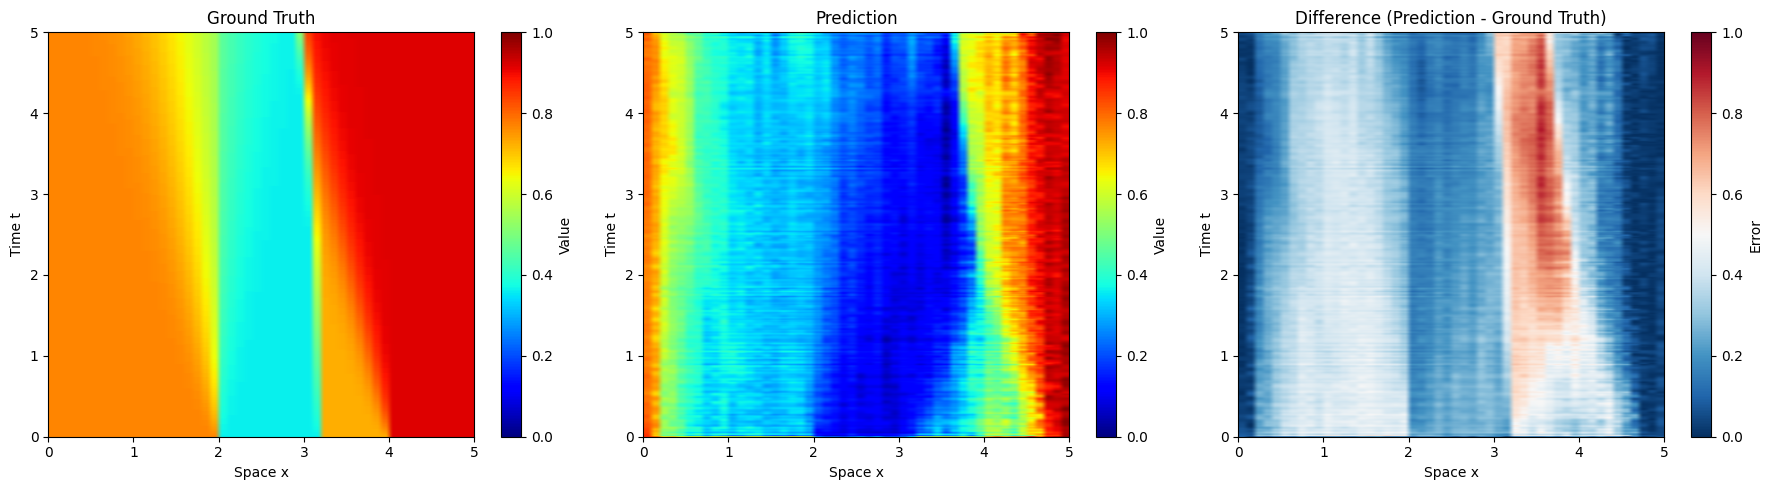

Saved comparison plot as super_resolution_test_0.png


In [8]:
# Plot comparison
plot_comparison(target_np, pred_np, high_nx, high_nt, high_dx, high_dt)
plt.show()

print(f"Saved comparison plot as super_resolution_test_{sample_idx}.png")


## 5. Test Multiple Samples (Optional)


In [9]:
# Test all samples and compute average metrics
mse_list = []
mae_list = []

for idx in range(len(high_res_dataset)):
    input_data, target_data = high_res_dataset[idx]
    input_batch = input_data.unsqueeze(0).to(device)
    target_batch = target_data.unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(input_batch)
    
    pred_np = prediction[0, 0].cpu().numpy()
    target_np = target_batch[0, 0].cpu().numpy()
    
    mse = np.mean((pred_np - target_np) ** 2)
    mae = np.mean(np.abs(pred_np - target_np))
    
    mse_list.append(mse)
    mae_list.append(mae)

print(f"\nAverage MSE: {np.mean(mse_list):.6f} ± {np.std(mse_list):.6f}")
print(f"Average MAE: {np.mean(mae_list):.6f} ± {np.std(mae_list):.6f}")



Average MSE: 0.111693 ± 0.073136
Average MAE: 0.258564 ± 0.116193
